In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = 3


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                        | 0/60000 [00:00<?, ?it/s]

 10%|█████████▎                                                                                | 6195/60000 [00:00<00:00, 61941.20it/s]

 22%|███████████████████▏                                                                     | 12939/60000 [00:00<00:00, 65171.34it/s]

 33%|█████████████████████████████▎                                                           | 19723/60000 [00:00<00:00, 66385.95it/s]

 44%|███████████████████████████████████████▏                                                 | 26434/60000 [00:00<00:00, 66670.86it/s]

 55%|█████████████████████████████████████████████████▏                                       | 33183/60000 [00:00<00:00, 66963.78it/s]

 67%|███████████████████████████████████████████████████████████▎                             | 39944/60000 [00:00<00:00, 67180.72it/s]

 78%|█████████████████████████████████████████████████████████████████████▎                   | 46697/60000 [00:00<00:00, 67292.51it/s]

 89%|███████████████████████████████████████████████████████████████████████████████▎         | 53452/60000 [00:00<00:00, 67372.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 66785.20it/s]

  0%|                                                                                                        | 0/10000 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████▍                             | 6716/10000 [00:00<00:00, 67151.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 66343.63it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

3 cto6ipr0


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                          | 0/674 [00:00<?, ?it/s]

  0%|▏                                                                                                 | 1/674 [00:00<07:56,  1.41it/s]

  1%|▌                                                                                                 | 4/674 [00:00<01:48,  6.20it/s]

  1%|█▏                                                                                                | 8/674 [00:00<00:54, 12.27it/s]

  2%|█▋                                                                                               | 12/674 [00:01<00:37, 17.44it/s]

  2%|██▎                                                                                              | 16/674 [00:01<00:30, 21.70it/s]

  3%|██▉                                                                                              | 20/674 [00:01<00:26, 25.05it/s]

  4%|███▍                                                                                             | 24/674 [00:01<00:23, 27.60it/s]

  4%|████                                                                                             | 28/674 [00:01<00:21, 29.43it/s]

  5%|████▌                                                                                            | 32/674 [00:01<00:20, 30.68it/s]

  5%|█████▏                                                                                           | 36/674 [00:01<00:20, 31.74it/s]

  6%|█████▊                                                                                           | 40/674 [00:01<00:19, 32.51it/s]

  7%|██████▎                                                                                          | 44/674 [00:01<00:19, 32.18it/s]

  7%|██████▉                                                                                          | 48/674 [00:02<00:19, 32.72it/s]

  8%|███████▍                                                                                         | 52/674 [00:02<00:18, 33.20it/s]

  8%|████████                                                                                         | 56/674 [00:02<00:18, 33.50it/s]

  9%|████████▋                                                                                        | 60/674 [00:02<00:18, 33.75it/s]

  9%|█████████▏                                                                                       | 64/674 [00:02<00:17, 33.92it/s]

 10%|█████████▊                                                                                       | 68/674 [00:02<00:17, 34.00it/s]

 11%|██████████▎                                                                                      | 72/674 [00:02<00:17, 34.04it/s]

 11%|██████████▉                                                                                      | 76/674 [00:02<00:17, 34.16it/s]

 12%|███████████▌                                                                                     | 80/674 [00:03<00:17, 34.18it/s]

 12%|████████████                                                                                     | 84/674 [00:03<00:17, 34.26it/s]

 13%|████████████▋                                                                                    | 88/674 [00:03<00:17, 34.13it/s]

 14%|█████████████▏                                                                                   | 92/674 [00:03<00:17, 34.16it/s]

 14%|█████████████▊                                                                                   | 96/674 [00:03<00:16, 34.20it/s]

 15%|██████████████▏                                                                                 | 100/674 [00:03<00:16, 33.92it/s]

 15%|██████████████▊                                                                                 | 104/674 [00:03<00:17, 33.07it/s]

 16%|███████████████▍                                                                                | 108/674 [00:03<00:16, 33.41it/s]

 17%|███████████████▉                                                                                | 112/674 [00:03<00:16, 33.61it/s]

 17%|████████████████▌                                                                               | 116/674 [00:04<00:16, 33.79it/s]

 18%|█████████████████                                                                               | 120/674 [00:04<00:16, 33.90it/s]

 18%|█████████████████▋                                                                              | 124/674 [00:04<00:16, 33.95it/s]

 19%|██████████████████▏                                                                             | 128/674 [00:04<00:16, 34.03it/s]

 20%|██████████████████▊                                                                             | 132/674 [00:04<00:15, 34.08it/s]

 20%|███████████████████▎                                                                            | 136/674 [00:04<00:15, 34.08it/s]

 21%|███████████████████▉                                                                            | 140/674 [00:04<00:15, 34.16it/s]

 21%|████████████████████▌                                                                           | 144/674 [00:04<00:15, 34.19it/s]

 22%|█████████████████████                                                                           | 148/674 [00:05<00:15, 34.21it/s]

 23%|█████████████████████▋                                                                          | 152/674 [00:05<00:15, 34.17it/s]

 23%|██████████████████████▏                                                                         | 156/674 [00:05<00:15, 34.20it/s]

 24%|██████████████████████▊                                                                         | 160/674 [00:05<00:15, 34.19it/s]

 24%|███████████████████████▎                                                                        | 164/674 [00:05<00:14, 34.17it/s]

 25%|███████████████████████▉                                                                        | 168/674 [00:05<00:14, 34.15it/s]

 26%|████████████████████████▍                                                                       | 172/674 [00:05<00:14, 34.11it/s]

 26%|█████████████████████████                                                                       | 176/674 [00:05<00:14, 34.13it/s]

 27%|█████████████████████████▋                                                                      | 180/674 [00:05<00:14, 33.39it/s]

 27%|██████████████████████████▏                                                                     | 184/674 [00:06<00:14, 33.57it/s]

 28%|██████████████████████████▊                                                                     | 188/674 [00:06<00:14, 33.67it/s]

 28%|███████████████████████████▎                                                                    | 192/674 [00:06<00:14, 33.82it/s]

 29%|███████████████████████████▉                                                                    | 196/674 [00:06<00:14, 33.87it/s]

 30%|████████████████████████████▍                                                                   | 200/674 [00:06<00:13, 33.99it/s]

 30%|█████████████████████████████                                                                   | 204/674 [00:06<00:13, 34.00it/s]

 31%|█████████████████████████████▋                                                                  | 208/674 [00:06<00:13, 34.07it/s]

 31%|██████████████████████████████▏                                                                 | 212/674 [00:06<00:13, 34.00it/s]

 32%|██████████████████████████████▊                                                                 | 216/674 [00:07<00:13, 33.82it/s]

 33%|███████████████████████████████▎                                                                | 220/674 [00:07<00:13, 33.66it/s]

 33%|███████████████████████████████▉                                                                | 224/674 [00:07<00:13, 33.54it/s]

 34%|████████████████████████████████▍                                                               | 228/674 [00:07<00:13, 33.54it/s]

 34%|█████████████████████████████████                                                               | 232/674 [00:07<00:13, 33.53it/s]

 35%|█████████████████████████████████▌                                                              | 236/674 [00:07<00:13, 33.46it/s]

 36%|██████████████████████████████████▏                                                             | 240/674 [00:07<00:13, 33.16it/s]

 36%|██████████████████████████████████▊                                                             | 244/674 [00:07<00:12, 33.37it/s]

 37%|███████████████████████████████████▎                                                            | 248/674 [00:08<00:12, 32.88it/s]

 37%|███████████████████████████████████▉                                                            | 252/674 [00:08<00:12, 33.21it/s]

 38%|████████████████████████████████████▍                                                           | 256/674 [00:08<00:12, 33.58it/s]

 39%|█████████████████████████████████████                                                           | 260/674 [00:08<00:12, 33.81it/s]

 39%|█████████████████████████████████████▌                                                          | 264/674 [00:08<00:12, 33.90it/s]

 40%|██████████████████████████████████████▏                                                         | 268/674 [00:08<00:11, 34.00it/s]

 40%|██████████████████████████████████████▋                                                         | 272/674 [00:08<00:11, 34.04it/s]

 41%|███████████████████████████████████████▎                                                        | 276/674 [00:08<00:11, 34.09it/s]

 42%|███████████████████████████████████████▉                                                        | 280/674 [00:08<00:11, 34.17it/s]

 42%|████████████████████████████████████████▍                                                       | 284/674 [00:09<00:11, 34.15it/s]

 43%|█████████████████████████████████████████                                                       | 288/674 [00:09<00:11, 34.14it/s]

 43%|█████████████████████████████████████████▌                                                      | 292/674 [00:09<00:11, 34.18it/s]

 44%|██████████████████████████████████████████▏                                                     | 296/674 [00:09<00:11, 34.19it/s]

 45%|██████████████████████████████████████████▋                                                     | 300/674 [00:09<00:10, 34.22it/s]

 45%|███████████████████████████████████████████▎                                                    | 304/674 [00:09<00:10, 34.04it/s]

 46%|███████████████████████████████████████████▊                                                    | 308/674 [00:09<00:10, 34.06it/s]

 46%|████████████████████████████████████████████▍                                                   | 312/674 [00:09<00:10, 34.10it/s]

 47%|█████████████████████████████████████████████                                                   | 316/674 [00:10<00:10, 33.98it/s]

 47%|█████████████████████████████████████████████▌                                                  | 320/674 [00:10<00:10, 33.99it/s]

 48%|██████████████████████████████████████████████▏                                                 | 324/674 [00:10<00:10, 34.06it/s]

 49%|██████████████████████████████████████████████▋                                                 | 328/674 [00:10<00:10, 34.06it/s]

 49%|███████████████████████████████████████████████▎                                                | 332/674 [00:10<00:10, 34.07it/s]

 50%|███████████████████████████████████████████████▊                                                | 336/674 [00:10<00:09, 34.07it/s]

 50%|████████████████████████████████████████████████▍                                               | 340/674 [00:10<00:09, 34.13it/s]

 51%|████████████████████████████████████████████████▉                                               | 344/674 [00:10<00:09, 34.15it/s]

 52%|█████████████████████████████████████████████████▌                                              | 348/674 [00:10<00:09, 34.15it/s]

 52%|██████████████████████████████████████████████████▏                                             | 352/674 [00:11<00:09, 33.95it/s]

 53%|██████████████████████████████████████████████████▋                                             | 356/674 [00:11<00:09, 33.56it/s]

 53%|███████████████████████████████████████████████████▎                                            | 360/674 [00:11<00:09, 33.49it/s]

 54%|███████████████████████████████████████████████████▊                                            | 364/674 [00:11<00:09, 33.59it/s]

 55%|████████████████████████████████████████████████████▍                                           | 368/674 [00:11<00:09, 33.80it/s]

 55%|████████████████████████████████████████████████████▉                                           | 372/674 [00:11<00:08, 34.11it/s]

 56%|█████████████████████████████████████████████████████▌                                          | 376/674 [00:11<00:08, 34.26it/s]

 56%|██████████████████████████████████████████████████████                                          | 380/674 [00:11<00:08, 34.23it/s]

 57%|██████████████████████████████████████████████████████▋                                         | 384/674 [00:12<00:08, 34.23it/s]

 58%|███████████████████████████████████████████████████████▎                                        | 388/674 [00:12<00:08, 34.25it/s]

 58%|███████████████████████████████████████████████████████▊                                        | 392/674 [00:12<00:08, 34.25it/s]

 59%|████████████████████████████████████████████████████████▍                                       | 396/674 [00:12<00:08, 34.38it/s]

 59%|████████████████████████████████████████████████████████▉                                       | 400/674 [00:12<00:07, 34.40it/s]

 60%|█████████████████████████████████████████████████████████▌                                      | 404/674 [00:12<00:07, 34.16it/s]

 61%|██████████████████████████████████████████████████████████                                      | 408/674 [00:12<00:07, 34.14it/s]

 61%|██████████████████████████████████████████████████████████▋                                     | 412/674 [00:12<00:07, 34.22it/s]

 62%|███████████████████████████████████████████████████████████▎                                    | 416/674 [00:12<00:07, 34.32it/s]

 62%|███████████████████████████████████████████████████████████▊                                    | 420/674 [00:13<00:07, 34.34it/s]

 63%|████████████████████████████████████████████████████████████▍                                   | 424/674 [00:13<00:07, 34.40it/s]

 64%|████████████████████████████████████████████████████████████▉                                   | 428/674 [00:13<00:07, 34.34it/s]

 64%|█████████████████████████████████████████████████████████████▌                                  | 432/674 [00:13<00:07, 34.26it/s]

 65%|██████████████████████████████████████████████████████████████                                  | 436/674 [00:13<00:06, 34.23it/s]

 65%|██████████████████████████████████████████████████████████████▋                                 | 440/674 [00:13<00:06, 34.14it/s]

 66%|███████████████████████████████████████████████████████████████▏                                | 444/674 [00:13<00:06, 34.15it/s]

 66%|███████████████████████████████████████████████████████████████▊                                | 448/674 [00:13<00:06, 34.15it/s]

 67%|████████████████████████████████████████████████████████████████▍                               | 452/674 [00:13<00:06, 34.10it/s]

 68%|████████████████████████████████████████████████████████████████▉                               | 456/674 [00:14<00:06, 34.06it/s]

 68%|█████████████████████████████████████████████████████████████████▌                              | 460/674 [00:14<00:06, 34.11it/s]

 69%|██████████████████████████████████████████████████████████████████                              | 464/674 [00:14<00:06, 34.21it/s]

 69%|██████████████████████████████████████████████████████████████████▋                             | 468/674 [00:14<00:06, 33.57it/s]

 70%|███████████████████████████████████████████████████████████████████▏                            | 472/674 [00:14<00:05, 33.84it/s]

 71%|███████████████████████████████████████████████████████████████████▊                            | 476/674 [00:14<00:05, 34.02it/s]

 71%|████████████████████████████████████████████████████████████████████▎                           | 480/674 [00:14<00:05, 34.21it/s]

 72%|████████████████████████████████████████████████████████████████████▉                           | 484/674 [00:14<00:05, 34.24it/s]

 72%|█████████████████████████████████████████████████████████████████████▌                          | 488/674 [00:15<00:05, 34.38it/s]

 73%|██████████████████████████████████████████████████████████████████████                          | 492/674 [00:15<00:05, 34.39it/s]

 74%|██████████████████████████████████████████████████████████████████████▋                         | 496/674 [00:15<00:05, 34.27it/s]

 74%|███████████████████████████████████████████████████████████████████████▏                        | 500/674 [00:15<00:05, 34.34it/s]

 75%|███████████████████████████████████████████████████████████████████████▊                        | 504/674 [00:15<00:04, 34.42it/s]

 75%|████████████████████████████████████████████████████████████████████████▎                       | 508/674 [00:15<00:04, 34.40it/s]

 76%|████████████████████████████████████████████████████████████████████████▉                       | 512/674 [00:15<00:04, 34.03it/s]

 77%|█████████████████████████████████████████████████████████████████████████▍                      | 516/674 [00:15<00:04, 34.02it/s]

 77%|██████████████████████████████████████████████████████████████████████████                      | 520/674 [00:15<00:04, 34.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████▋                     | 524/674 [00:16<00:04, 34.10it/s]

 78%|███████████████████████████████████████████████████████████████████████████▏                    | 528/674 [00:16<00:04, 34.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████▊                    | 532/674 [00:16<00:04, 34.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████▎                   | 536/674 [00:16<00:04, 34.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████▉                   | 540/674 [00:16<00:03, 34.31it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▍                  | 544/674 [00:16<00:03, 34.36it/s]

 81%|██████████████████████████████████████████████████████████████████████████████                  | 548/674 [00:16<00:03, 34.46it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▌                 | 552/674 [00:16<00:03, 34.51it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▏                | 556/674 [00:17<00:03, 34.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▊                | 560/674 [00:17<00:03, 34.26it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▎               | 564/674 [00:17<00:03, 34.41it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▉               | 568/674 [00:17<00:03, 34.51it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████▍              | 572/674 [00:17<00:02, 34.44it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████              | 576/674 [00:17<00:02, 34.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▌             | 580/674 [00:17<00:02, 34.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 584/674 [00:17<00:02, 34.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▊            | 588/674 [00:17<00:02, 34.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▎           | 592/674 [00:18<00:02, 34.30it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▉           | 596/674 [00:18<00:02, 34.32it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▍          | 600/674 [00:18<00:02, 34.30it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████          | 604/674 [00:18<00:02, 34.22it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▌         | 608/674 [00:18<00:01, 34.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▏        | 612/674 [00:18<00:01, 34.17it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▋        | 616/674 [00:18<00:01, 34.06it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 620/674 [00:18<00:01, 34.17it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▉       | 624/674 [00:19<00:01, 34.26it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▍      | 628/674 [00:19<00:01, 34.11it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████      | 632/674 [00:19<00:01, 34.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 636/674 [00:19<00:01, 33.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▏    | 640/674 [00:19<00:01, 33.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▋    | 644/674 [00:19<00:00, 34.01it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 648/674 [00:19<00:00, 34.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▊   | 652/674 [00:19<00:00, 34.05it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▍  | 656/674 [00:19<00:00, 34.10it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████  | 660/674 [00:20<00:00, 34.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▌ | 664/674 [00:20<00:00, 34.05it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 668/674 [00:20<00:00, 34.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████▋| 672/674 [00:20<00:00, 34.97it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 674/674 [00:20<00:00, 32.78it/s]

train - OK


  0%|                                                                                                          | 0/169 [00:00<?, ?it/s]

  1%|▌                                                                                                 | 1/169 [00:00<00:26,  6.46it/s]

  3%|██▉                                                                                               | 5/169 [00:00<00:08, 20.07it/s]

  5%|█████▏                                                                                            | 9/169 [00:00<00:06, 25.80it/s]

  8%|███████▍                                                                                         | 13/169 [00:00<00:05, 28.85it/s]

 10%|█████████▊                                                                                       | 17/169 [00:00<00:04, 30.61it/s]

 12%|████████████                                                                                     | 21/169 [00:00<00:04, 31.69it/s]

 15%|██████████████▎                                                                                  | 25/169 [00:00<00:04, 32.30it/s]

 17%|████████████████▋                                                                                | 29/169 [00:00<00:04, 32.81it/s]

 20%|██████████████████▉                                                                              | 33/169 [00:01<00:04, 33.17it/s]

 22%|█████████████████████▏                                                                           | 37/169 [00:01<00:03, 33.49it/s]

 24%|███████████████████████▌                                                                         | 41/169 [00:01<00:03, 33.61it/s]

 27%|█████████████████████████▊                                                                       | 45/169 [00:01<00:03, 33.69it/s]

 29%|████████████████████████████                                                                     | 49/169 [00:01<00:03, 33.75it/s]

 31%|██████████████████████████████▍                                                                  | 53/169 [00:01<00:03, 33.85it/s]

 34%|████████████████████████████████▋                                                                | 57/169 [00:01<00:03, 33.89it/s]

 36%|███████████████████████████████████                                                              | 61/169 [00:01<00:03, 33.89it/s]

 38%|█████████████████████████████████████▎                                                           | 65/169 [00:02<00:03, 33.92it/s]

 41%|███████████████████████████████████████▌                                                         | 69/169 [00:02<00:02, 33.95it/s]

 43%|█████████████████████████████████████████▉                                                       | 73/169 [00:02<00:02, 33.90it/s]

 46%|████████████████████████████████████████████▏                                                    | 77/169 [00:02<00:02, 33.96it/s]

 48%|██████████████████████████████████████████████▍                                                  | 81/169 [00:02<00:02, 33.73it/s]

 50%|████████████████████████████████████████████████▊                                                | 85/169 [00:02<00:02, 33.84it/s]

 53%|███████████████████████████████████████████████████                                              | 89/169 [00:02<00:02, 33.84it/s]

 55%|█████████████████████████████████████████████████████▍                                           | 93/169 [00:02<00:02, 33.88it/s]

 57%|███████████████████████████████████████████████████████▋                                         | 97/169 [00:02<00:02, 33.86it/s]

 60%|█████████████████████████████████████████████████████████▎                                      | 101/169 [00:03<00:02, 33.84it/s]

 62%|███████████████████████████████████████████████████████████▋                                    | 105/169 [00:03<00:01, 33.90it/s]

 64%|█████████████████████████████████████████████████████████████▉                                  | 109/169 [00:03<00:01, 33.88it/s]

 67%|████████████████████████████████████████████████████████████████▏                               | 113/169 [00:03<00:01, 33.91it/s]

 69%|██████████████████████████████████████████████████████████████████▍                             | 117/169 [00:03<00:01, 33.94it/s]

 72%|████████████████████████████████████████████████████████████████████▋                           | 121/169 [00:03<00:01, 33.96it/s]

 74%|███████████████████████████████████████████████████████████████████████                         | 125/169 [00:03<00:01, 34.02it/s]

 76%|█████████████████████████████████████████████████████████████████████████▎                      | 129/169 [00:03<00:01, 34.04it/s]

 79%|███████████████████████████████████████████████████████████████████████████▌                    | 133/169 [00:04<00:01, 34.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 137/169 [00:04<00:00, 34.04it/s]

 83%|████████████████████████████████████████████████████████████████████████████████                | 141/169 [00:04<00:00, 33.99it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▎             | 145/169 [00:04<00:00, 33.95it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▋           | 149/169 [00:04<00:00, 33.98it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▉         | 153/169 [00:04<00:00, 33.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▏      | 157/169 [00:04<00:00, 33.94it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████▍    | 161/169 [00:04<00:00, 33.93it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▋  | 165/169 [00:04<00:00, 34.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 33.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:05<00:00, 32.80it/s]

val - OK


  0%|                                                                                                          | 0/141 [00:00<?, ?it/s]

  1%|▋                                                                                                 | 1/141 [00:00<00:19,  7.19it/s]

  4%|███▍                                                                                              | 5/141 [00:00<00:06, 21.43it/s]

  6%|██████▎                                                                                           | 9/141 [00:00<00:04, 27.04it/s]

  9%|████████▉                                                                                        | 13/141 [00:00<00:04, 29.62it/s]

 12%|███████████▋                                                                                     | 17/141 [00:00<00:03, 31.11it/s]

 15%|██████████████▍                                                                                  | 21/141 [00:00<00:03, 31.99it/s]

 18%|█████████████████▏                                                                               | 25/141 [00:00<00:03, 32.51it/s]

 21%|███████████████████▉                                                                             | 29/141 [00:00<00:03, 32.97it/s]

 23%|██████████████████████▋                                                                          | 33/141 [00:01<00:03, 32.87it/s]

 26%|█████████████████████████▍                                                                       | 37/141 [00:01<00:03, 33.16it/s]

 29%|████████████████████████████▏                                                                    | 41/141 [00:01<00:02, 33.42it/s]

 32%|██████████████████████████████▉                                                                  | 45/141 [00:01<00:02, 33.69it/s]

 35%|█████████████████████████████████▋                                                               | 49/141 [00:01<00:02, 33.82it/s]

 38%|████████████████████████████████████▍                                                            | 53/141 [00:01<00:02, 33.90it/s]

 40%|███████████████████████████████████████▏                                                         | 57/141 [00:01<00:02, 33.98it/s]

 43%|█████████████████████████████████████████▉                                                       | 61/141 [00:01<00:02, 34.12it/s]

 46%|████████████████████████████████████████████▋                                                    | 65/141 [00:02<00:02, 34.10it/s]

 49%|███████████████████████████████████████████████▍                                                 | 69/141 [00:02<00:02, 34.14it/s]

 52%|██████████████████████████████████████████████████▏                                              | 73/141 [00:02<00:01, 34.17it/s]

 55%|████████████████████████████████████████████████████▉                                            | 77/141 [00:02<00:01, 34.21it/s]

 57%|███████████████████████████████████████████████████████▋                                         | 81/141 [00:02<00:01, 34.25it/s]

 60%|██████████████████████████████████████████████████████████▍                                      | 85/141 [00:02<00:01, 34.26it/s]

 63%|█████████████████████████████████████████████████████████████▏                                   | 89/141 [00:02<00:01, 34.38it/s]

 66%|███████████████████████████████████████████████████████████████▉                                 | 93/141 [00:02<00:01, 34.39it/s]

 69%|██████████████████████████████████████████████████████████████████▋                              | 97/141 [00:02<00:01, 34.38it/s]

 72%|████████████████████████████████████████████████████████████████████▊                           | 101/141 [00:03<00:01, 34.39it/s]

 74%|███████████████████████████████████████████████████████████████████████▍                        | 105/141 [00:03<00:01, 34.31it/s]

 77%|██████████████████████████████████████████████████████████████████████████▏                     | 109/141 [00:03<00:00, 34.25it/s]

 80%|████████████████████████████████████████████████████████████████████████████▉                   | 113/141 [00:03<00:00, 34.21it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▋                | 117/141 [00:03<00:00, 34.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▍             | 121/141 [00:03<00:00, 33.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████           | 125/141 [00:03<00:00, 33.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████▊        | 129/141 [00:03<00:00, 33.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████▌     | 133/141 [00:04<00:00, 34.04it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▎  | 137/141 [00:04<00:00, 34.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 32.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 32.77it/s]

test InD - OK


  0%|                                                                                                          | 0/112 [00:00<?, ?it/s]

  1%|▉                                                                                                 | 1/112 [00:00<00:16,  6.89it/s]

  4%|████▍                                                                                             | 5/112 [00:00<00:05, 21.11it/s]

  8%|███████▉                                                                                          | 9/112 [00:00<00:03, 26.71it/s]

 12%|███████████▎                                                                                     | 13/112 [00:00<00:03, 29.25it/s]

 15%|██████████████▋                                                                                  | 17/112 [00:00<00:03, 30.74it/s]

 19%|██████████████████▏                                                                              | 21/112 [00:00<00:02, 31.76it/s]

 22%|█████████████████████▋                                                                           | 25/112 [00:00<00:02, 32.39it/s]

 26%|█████████████████████████                                                                        | 29/112 [00:00<00:02, 32.88it/s]

 29%|████████████████████████████▌                                                                    | 33/112 [00:01<00:02, 33.17it/s]

 33%|████████████████████████████████                                                                 | 37/112 [00:01<00:02, 33.41it/s]

 37%|███████████████████████████████████▌                                                             | 41/112 [00:01<00:02, 33.50it/s]

 40%|██████████████████████████████████████▉                                                          | 45/112 [00:01<00:01, 33.61it/s]

 44%|██████████████████████████████████████████▍                                                      | 49/112 [00:01<00:01, 33.67it/s]

 47%|█████████████████████████████████████████████▉                                                   | 53/112 [00:01<00:01, 33.74it/s]

 51%|█████████████████████████████████████████████████▎                                               | 57/112 [00:01<00:01, 33.83it/s]

 54%|████████████████████████████████████████████████████▊                                            | 61/112 [00:01<00:01, 33.84it/s]

 58%|████████████████████████████████████████████████████████▎                                        | 65/112 [00:02<00:01, 33.81it/s]

 62%|███████████████████████████████████████████████████████████▊                                     | 69/112 [00:02<00:01, 33.83it/s]

 65%|███████████████████████████████████████████████████████████████▏                                 | 73/112 [00:02<00:01, 33.84it/s]

 69%|██████████████████████████████████████████████████████████████████▋                              | 77/112 [00:02<00:01, 33.94it/s]

 72%|██████████████████████████████████████████████████████████████████████▏                          | 81/112 [00:02<00:00, 33.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████▌                       | 85/112 [00:02<00:00, 33.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████                    | 89/112 [00:02<00:00, 33.94it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▌                | 93/112 [00:02<00:00, 33.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████             | 97/112 [00:02<00:00, 33.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▌         | 101/112 [00:03<00:00, 33.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████      | 105/112 [00:03<00:00, 33.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▍  | 109/112 [00:03<00:00, 34.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:03<00:00, 32.29it/s]

test OoD - OK


  0%|                                                                                                          | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                              | 4/100 [00:00<00:02, 36.54it/s]

  8%|███████▊                                                                                          | 8/100 [00:00<00:02, 37.53it/s]

 12%|███████████▋                                                                                     | 12/100 [00:00<00:02, 37.88it/s]

 16%|███████████████▌                                                                                 | 16/100 [00:00<00:02, 38.00it/s]

 20%|███████████████████▍                                                                             | 20/100 [00:00<00:02, 38.19it/s]

 24%|███████████████████████▎                                                                         | 24/100 [00:00<00:01, 38.29it/s]

 28%|███████████████████████████▏                                                                     | 28/100 [00:00<00:01, 38.35it/s]

 32%|███████████████████████████████                                                                  | 32/100 [00:00<00:01, 38.38it/s]

 36%|██████████████████████████████████▉                                                              | 36/100 [00:00<00:01, 38.13it/s]

 40%|██████████████████████████████████████▊                                                          | 40/100 [00:01<00:01, 38.14it/s]

 44%|██████████████████████████████████████████▋                                                      | 44/100 [00:01<00:01, 38.23it/s]

 48%|██████████████████████████████████████████████▌                                                  | 48/100 [00:01<00:01, 38.14it/s]

 52%|██████████████████████████████████████████████████▍                                              | 52/100 [00:01<00:01, 38.21it/s]

 56%|██████████████████████████████████████████████████████▎                                          | 56/100 [00:01<00:01, 38.19it/s]

 60%|██████████████████████████████████████████████████████████▏                                      | 60/100 [00:01<00:01, 38.28it/s]

 64%|██████████████████████████████████████████████████████████████                                   | 64/100 [00:01<00:00, 37.82it/s]

 68%|█████████████████████████████████████████████████████████████████▉                               | 68/100 [00:01<00:00, 37.79it/s]

 72%|█████████████████████████████████████████████████████████████████████▊                           | 72/100 [00:01<00:00, 37.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████▋                       | 76/100 [00:02<00:00, 37.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 80/100 [00:02<00:00, 37.59it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 84/100 [00:02<00:00, 37.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 88/100 [00:02<00:00, 37.75it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 92/100 [00:02<00:00, 37.49it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [00:02<00:00, 37.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.88it/s]

test RnD - OK
(43095,) (43095,)
(10774,) (10774,)
(8990,) (8990,)
(7141,) (7141,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.273389 0.45712522
7.2679644 0.4472586
7.287735 0.44929123
7.385134 0.40821427
14.253046 0.77334166
11.434778 0.017808307
11.434962 0.017767988
11.434494 0.01799504
11.432864 0.018340955
27.44844 0.6425889


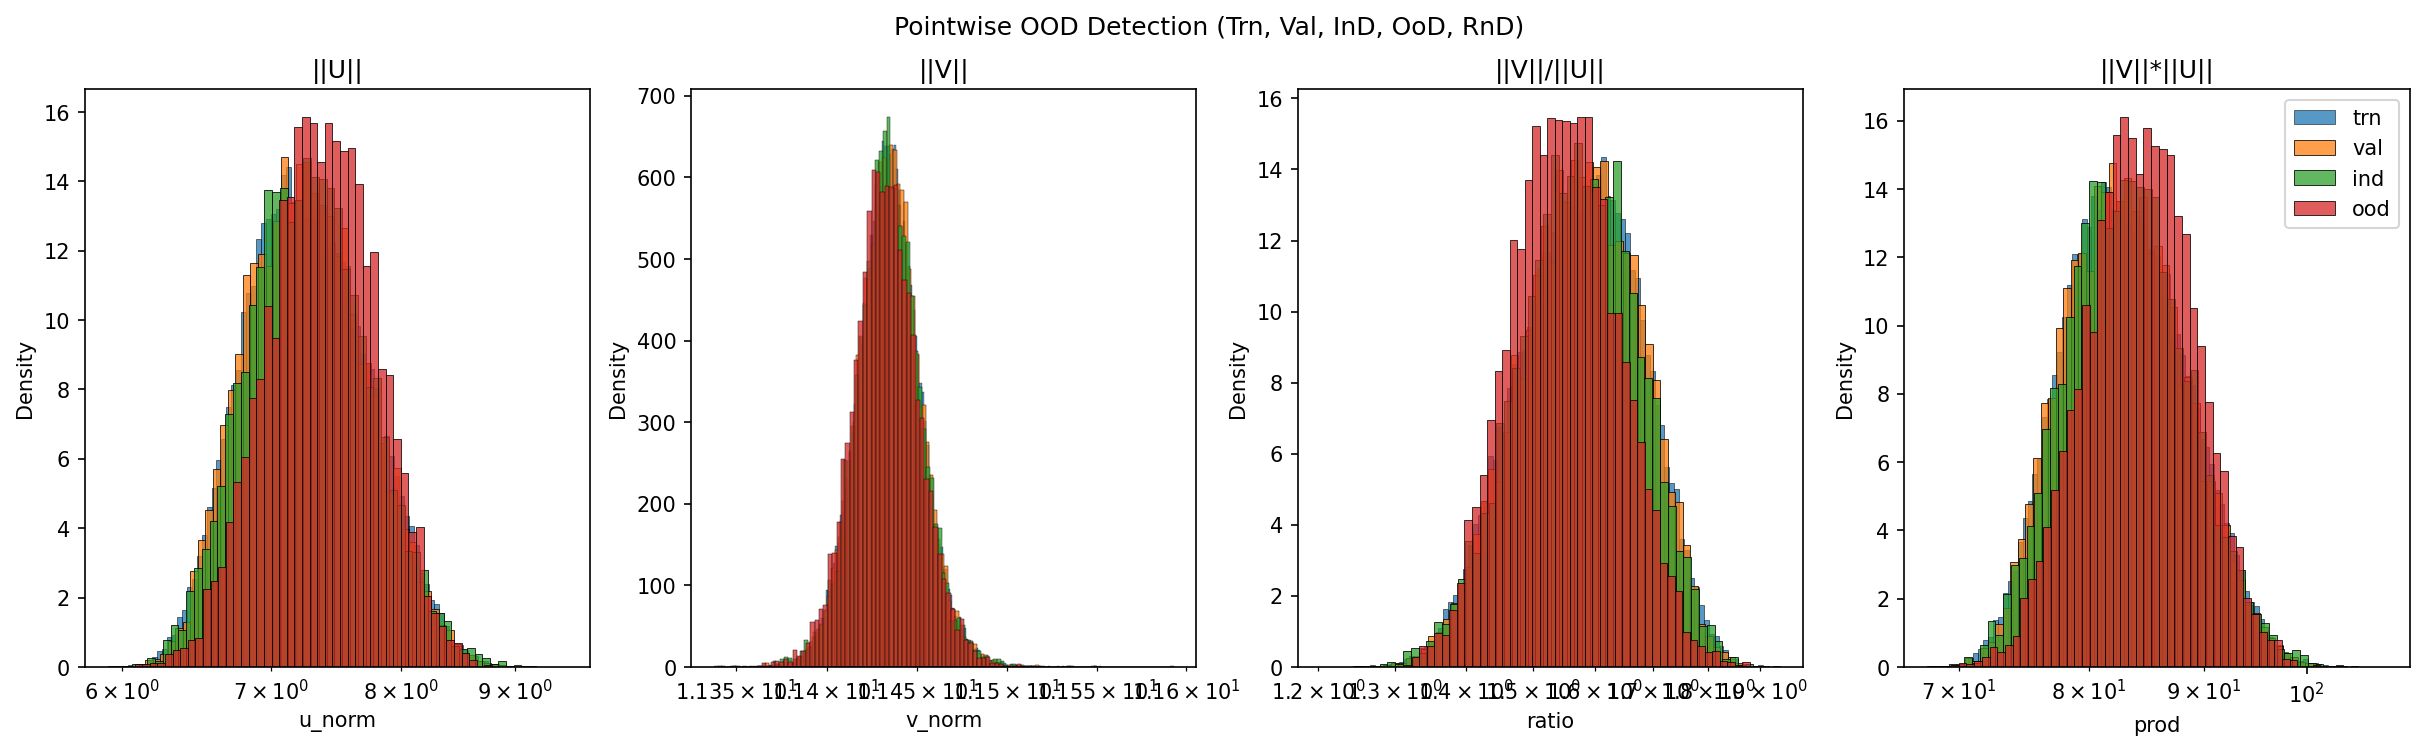

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 11.338186 11.552401 0.21421432
Val 11.342213 11.550214 0.20800114
Ind 11.37027 11.592755 0.22248554
Ood 11.340307 11.537004 0.19669724
Rnd 24.966032 30.282038 5.3160057
KstestResult(statistic=0.04619280879547036, pvalue=8.040620131071908e-08, statistic_location=11.427427, statistic_sign=-1)


[6, 2, 1, 0, 3, 8, 4, 5, 7, 9]


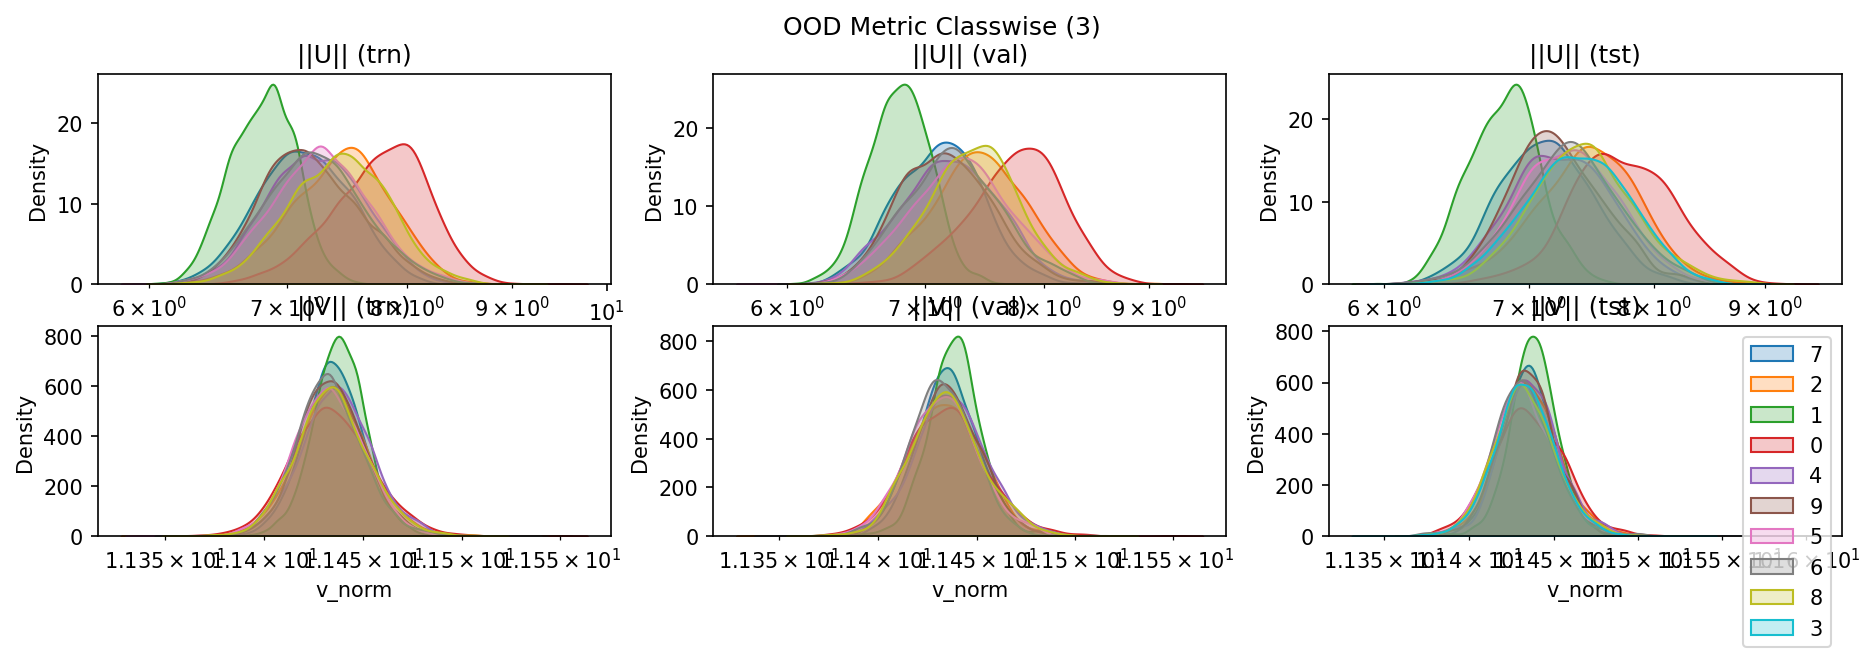

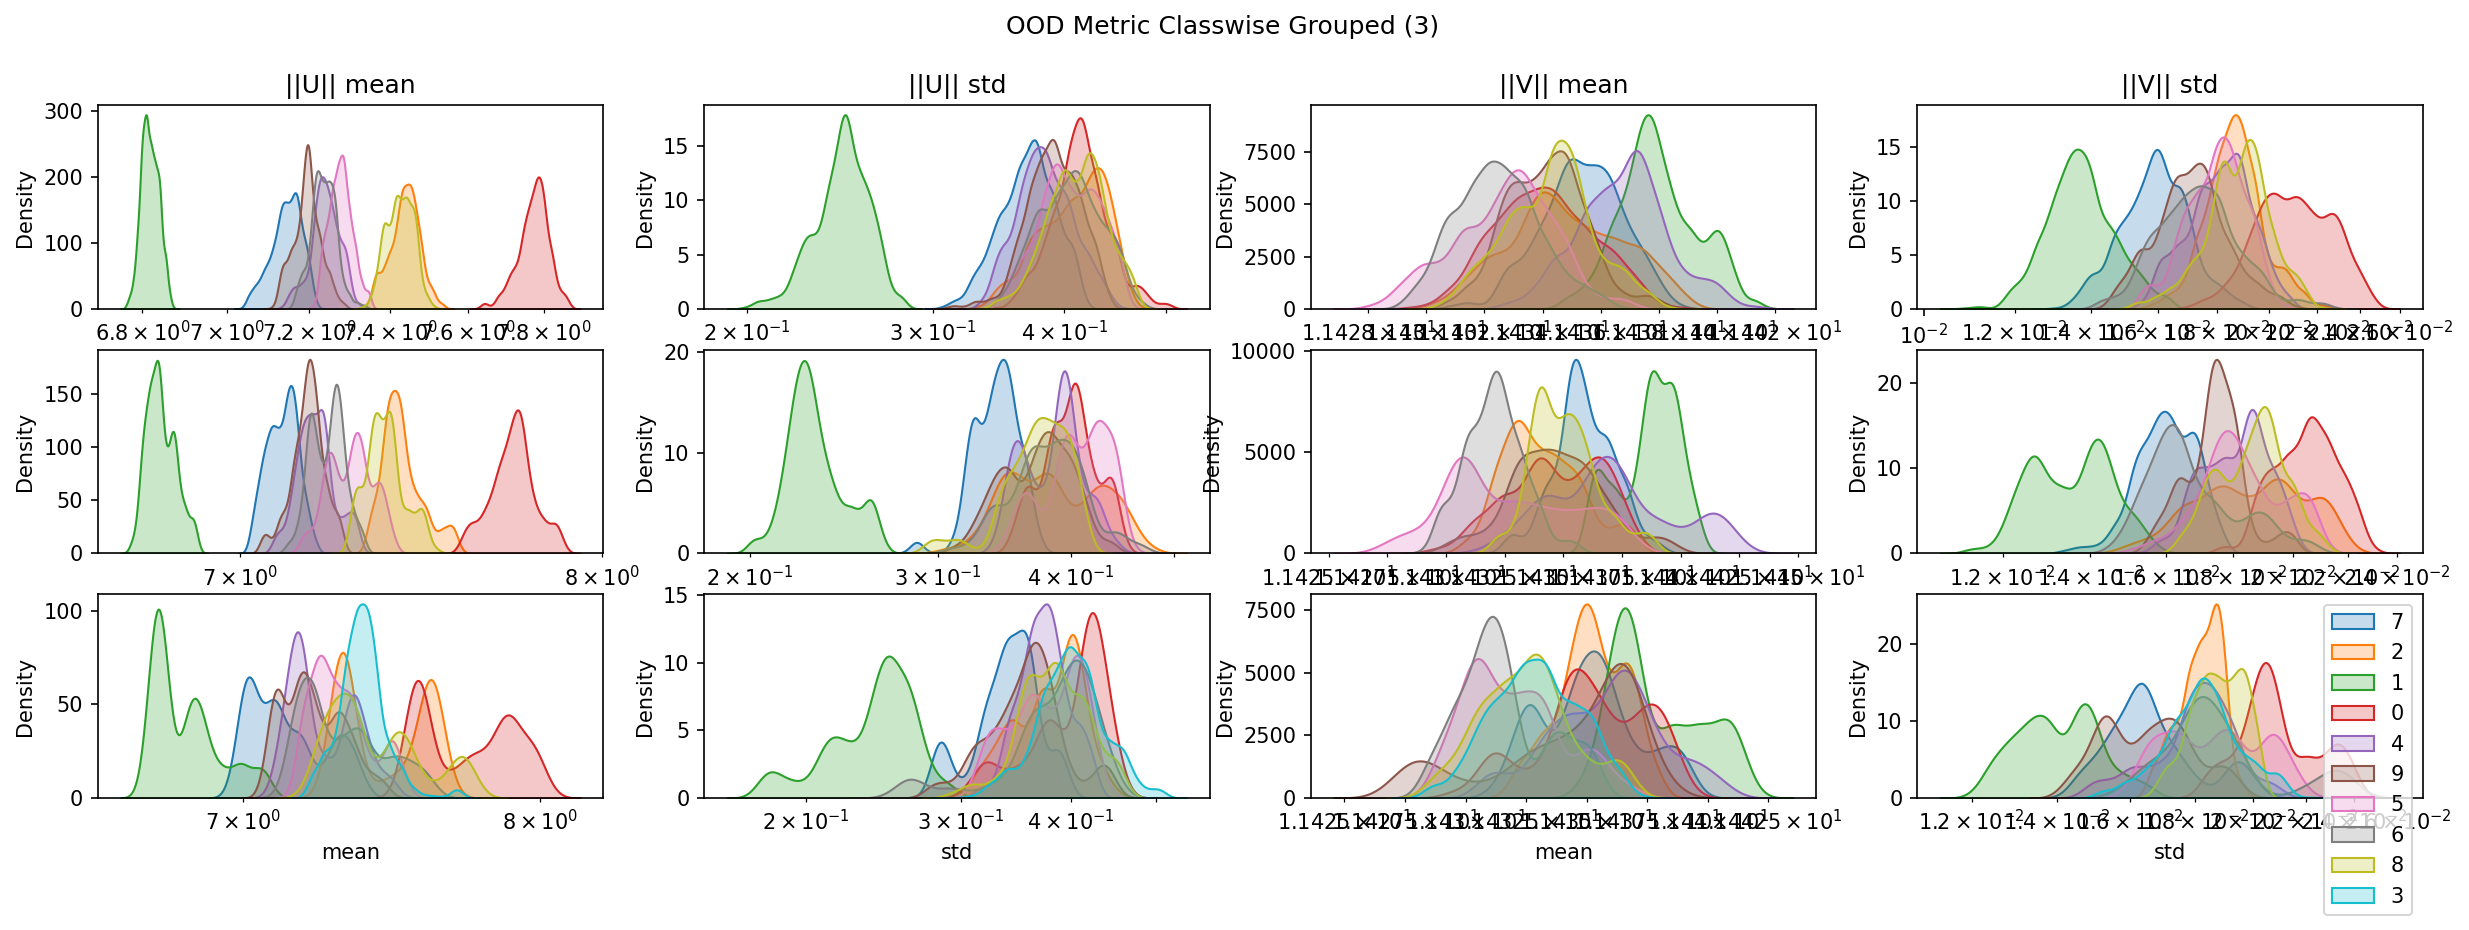

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
all_targets = list(data_tst['target'].unique())
print(all_targets)

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in all_targets:
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in all_targets:
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in all_targets:
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)